In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from collections import Counter
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling1D, AveragePooling1D
from keras.layers import Dense, Flatten, Dropout, Activation, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
%matplotlib inline

Using TensorFlow backend.


In [3]:
d_train = pd.read_csv('train_set.csv', delimiter=',')
d_train.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,43,management,married,tertiary,no,291,yes,no,unknown,9,may,150,2,-1,0,unknown,0
1,2,42,technician,divorced,primary,no,5076,yes,no,cellular,7,apr,99,1,251,2,other,0
2,3,47,admin.,married,secondary,no,104,yes,yes,cellular,14,jul,77,2,-1,0,unknown,0
3,4,28,management,single,secondary,no,-994,yes,yes,cellular,18,jul,174,2,-1,0,unknown,0
4,5,42,technician,divorced,secondary,no,2974,yes,no,unknown,21,may,187,5,-1,0,unknown,0


In [4]:
d_test = pd.read_csv('test_set.csv', delimiter=',')
d_test.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,25318,51,housemaid,married,unknown,no,174,no,no,telephone,29,jul,308,3,-1,0,unknown
1,25319,32,management,married,tertiary,no,6059,yes,no,cellular,20,nov,110,2,-1,0,unknown
2,25320,60,retired,married,primary,no,0,no,no,telephone,30,jul,130,3,-1,0,unknown
3,25321,32,student,single,tertiary,no,64,no,no,cellular,30,jun,598,4,105,5,failure
4,25322,41,housemaid,married,secondary,no,0,yes,yes,cellular,15,jul,368,4,-1,0,unknown


In [5]:
d_train.dtypes

ID            int64
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object

In [6]:
dataset_train = d_train
dataset_test = d_test

In [7]:
lh = LabelEncoder()
for col in dataset_train.columns[dataset_train.dtypes == 'object']:
    dataset_train[col] = lh.fit_transform(dataset_train[col])
dataset_train.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,43,4,1,2,0,291,1,0,2,9,8,150,2,-1,0,3,0
1,2,42,9,0,0,0,5076,1,0,0,7,0,99,1,251,2,1,0
2,3,47,0,1,1,0,104,1,1,0,14,5,77,2,-1,0,3,0
3,4,28,4,2,1,0,-994,1,1,0,18,5,174,2,-1,0,3,0
4,5,42,9,0,1,0,2974,1,0,2,21,8,187,5,-1,0,3,0


In [8]:
dataset_train.describe()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000
mean,12659.000000,40.935379,4.330687,1.167555,1.226291,0.017696,1357.555082,0.553778,0.160327,0.640163,15.835289,5.523166,257.732393,2.772050,40.248766,0.591737,2.558399,0.116957
std,7308.532719,10.634289,3.269565,0.608091,0.750483,0.131845,2999.822811,0.497109,0.366916,0.897537,8.319480,3.010054,256.975151,3.136097,100.213541,2.568313,0.989615,0.321375
min,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000,-8019.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
25%,6330.000000,33.000000,1.000000,1.000000,1.000000,0.000000,73.000000,0.000000,0.000000,0.000000,8.000000,3.000000,103.000000,1.000000,-1.000000,0.000000,3.000000,0.000000
50%,12659.000000,39.000000,4.000000,1.000000,1.000000,0.000000,448.000000,1.000000,0.000000,0.000000,16.000000,6.000000,181.000000,2.000000,-1.000000,0.000000,3.000000,0.000000
75%,18988.000000,48.000000,7.000000,2.000000,2.000000,0.000000,1435.000000,1.000000,0.000000,2.000000,21.000000,8.000000,317.000000,3.000000,-1.000000,0.000000,3.000000,0.000000
max,25317.000000,95.000000,11.000000,2.000000,3.000000,1.000000,102127.000000,1.000000,1.000000,2.000000,31.000000,11.000000,3881.000000,55.000000,854.000000,275.000000,3.000000,1.000000


In [9]:
dataset_train_y = dataset_train['y']
dataset_train_x = dataset_train[list(set(dataset_train.columns)-set(['y']))]
dataset_train_x.shape, dataset_train_y.shape

((25317, 17), (25317,))

In [10]:
for col in dataset_test.columns[dataset_test.dtypes == 'object']:
    dataset_test[col] = lh.fit_transform(dataset_test[col])
dataset_test.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,25318,51,3,1,3,0,174,0,0,1,29,5,308,3,-1,0,3
1,25319,32,4,1,2,0,6059,1,0,0,20,9,110,2,-1,0,3
2,25320,60,5,1,0,0,0,0,0,1,30,5,130,3,-1,0,3
3,25321,32,8,2,2,0,64,0,0,0,30,6,598,4,105,5,0
4,25322,41,3,1,1,0,0,1,1,0,15,5,368,4,-1,0,3


In [11]:
dataset_test.describe()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
count,10852.000000,10852.000000,10852.000000,10852.000000,10852.000000,10852.000000,10852.000000,10852.000000,10852.000000,10852.000000,10852.000000,10852.000000,10852.000000,10852.000000,10852.000000,10852.000000,10852.000000
mean,30743.500000,41.040638,4.372650,1.164947,1.226502,0.018153,1393.157298,0.547272,0.160984,0.637486,15.680151,5.509399,257.206137,2.770365,39.954755,0.546443,2.558975
std,3132.846895,10.652369,3.265972,0.602941,0.748990,0.133512,3318.497101,0.497783,0.367533,0.897054,8.302317,3.009708,250.480906,3.063481,99.524056,1.805938,0.993169
min,25318.000000,18.000000,0.000000,0.000000,0.000000,0.000000,-2604.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,28030.750000,33.000000,1.000000,1.000000,1.000000,0.000000,72.000000,0.000000,0.000000,0.000000,8.000000,3.000000,102.000000,1.000000,-1.000000,0.000000,3.000000
50%,30743.500000,39.000000,4.000000,1.000000,1.000000,0.000000,450.000000,1.000000,0.000000,0.000000,16.000000,6.000000,181.000000,2.000000,-1.000000,0.000000,3.000000
75%,33456.250000,49.000000,7.000000,2.000000,2.000000,0.000000,1440.250000,1.000000,0.000000,2.000000,21.000000,8.000000,322.000000,3.000000,-1.000000,0.000000,3.000000
max,36169.000000,94.000000,11.000000,2.000000,3.000000,1.000000,81204.000000,1.000000,1.000000,2.000000,31.000000,11.000000,3102.000000,58.000000,871.000000,51.000000,3.000000


In [12]:
dataset_all = pd.concat((dataset_train_x, dataset_test))
dataset_all.head()

E:\Anaconda\Software\envs\py3.5\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,ID,age,balance,campaign,contact,day,default,duration,education,housing,job,loan,marital,month,pdays,poutcome,previous
0,1,43,291,2,2,9,0,150,2,1,4,0,1,8,-1,3,0
1,2,42,5076,1,0,7,0,99,0,1,9,0,0,0,251,1,2
2,3,47,104,2,0,14,0,77,1,1,0,1,1,5,-1,3,0
3,4,28,-994,2,0,18,0,174,1,1,4,1,2,5,-1,3,0
4,5,42,2974,5,2,21,0,187,1,1,9,0,0,8,-1,3,0


In [13]:
ss = StandardScaler()
dataset_all[['balance', 'campaign', 'duration', 'education', 'pdays', 'poutcome', 'job']] = ss.fit_transform(dataset_all[['balance', 'campaign', 'duration', 'education', 'pdays', 'poutcome', 'job']])
dataset_all.head()

E:\Anaconda\Software\envs\py3.5\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
E:\Anaconda\Software\envs\py3.5\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,ID,age,balance,campaign,contact,day,default,duration,education,housing,job,loan,marital,month,pdays,poutcome,previous
0,1,43,-0.347627,-0.247734,2,9,0,-0.421799,1.031508,1,-0.105027,0,1,8,-0.411587,0.445592,0
1,2,42,1.196503,-0.568823,0,7,0,-0.621770,-1.635108,1,1.424748,0,0,0,2.108300,-1.573274,2
2,3,47,-0.407972,-0.247734,0,14,0,-0.708032,-0.301800,1,-1.328848,1,1,5,-0.411587,0.445592,0
3,4,28,-0.762299,-0.247734,0,18,0,-0.327695,-0.301800,1,-0.105027,1,2,5,-0.411587,0.445592,0
4,5,42,0.518183,0.715532,2,21,0,-0.276722,-0.301800,1,1.424748,0,0,8,-0.411587,0.445592,0


In [14]:
train_set = dataset_all.iloc[:25317,1:]
test_set = dataset_all.iloc[25317:,1:]

In [15]:
train_set_all = pd.concat([train_set, dataset_train_y], axis=1)
train_set_all.shape

(25317, 17)

In [16]:
age_counter = Counter(train_set['age'].values, reverse=False)
#age_counter

In [17]:
x_train, x_val, y_train, y_val = train_test_split(train_set.values, dataset_train_y.values, test_size=0.2, random_state=7)

In [18]:
x_train.shape, x_val.shape

((20253, 16), (5064, 16))

In [19]:
def create_model_fcn(units_list=[16], optimizer='adam', init='normal'):
    model = Sequential()
    units = units_list[0]
    model.add(Dense(units=units, activation='relu', input_dim=16, kernel_initializer=init))
    for units in units_list[1:]:
        model.add(Dense(units=units, activation='relu', kernel_initializer=init))
    model.add(Dense(units=1, activation='sigmoid', kernel_initializer=init))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [38]:
kfold = KFold(n_splits=7, shuffle=True, random_state=7)
k_model = KerasClassifier(build_fn=create_model_fcn, epochs=100, batch_size=20, verbose=1)
results = cross_val_score(k_model, x_train, y_train, cv=kfold)

Epoch 1/100
17359/17359 [==============================] - 2s 102us/step - loss: 0.3133 - acc: 0.8877
Epoch 2/100
17359/17359 [==============================] - 1s 63us/step - loss: 0.2615 - acc: 0.8926
Epoch 3/100
17359/17359 [==============================] - 1s 64us/step - loss: 0.2555 - acc: 0.8933
Epoch 4/100
17359/17359 [==============================] - 1s 65us/step - loss: 0.2513 - acc: 0.8948
Epoch 5/100
17359/17359 [==============================] - ETA: 0s - loss: 0.2481 - acc: 0.894 - 1s 66us/step - loss: 0.2478 - acc: 0.8952
Epoch 6/100
17359/17359 [==============================] - 1s 68us/step - loss: 0.2446 - acc: 0.8975
Epoch 7/100
17359/17359 [==============================] - 1s 66us/step - loss: 0.2438 - acc: 0.8987
Epoch 8/100
17359/17359 [==============================] - 1s 67us/step - loss: 0.2419 - acc: 0.8992
Epoch 9/100
17359/17359 [==============================] - 1s 67us/step - loss: 0.2410 - acc: 0.8999
Epoch 10/100
17359/17359 [==========================

17359/17359 [==============================] - 1s 65us/step - loss: 0.2211 - acc: 0.9068
Epoch 82/100
17359/17359 [==============================] - 1s 65us/step - loss: 0.2203 - acc: 0.9073
Epoch 83/100
17359/17359 [==============================] - 1s 66us/step - loss: 0.2206 - acc: 0.9069
Epoch 84/100
17359/17359 [==============================] - 1s 64us/step - loss: 0.2211 - acc: 0.9059
Epoch 85/100
17359/17359 [==============================] - 1s 65us/step - loss: 0.2208 - acc: 0.9058
Epoch 86/100
17359/17359 [==============================] - 1s 67us/step - loss: 0.2215 - acc: 0.9065
Epoch 87/100
17359/17359 [==============================] - 1s 65us/step - loss: 0.2203 - acc: 0.9070
Epoch 88/100
17359/17359 [==============================] - 1s 65us/step - loss: 0.2200 - acc: 0.9062
Epoch 89/100
17359/17359 [==============================] - 1s 66us/step - loss: 0.2205 - acc: 0.9067
Epoch 90/100
17359/17359 [==============================] - 1s 68us/step - loss: 0.2201 - acc: 

17360/17360 [==============================] - 1s 67us/step - loss: 0.2350 - acc: 0.9031
Epoch 40/100
17360/17360 [==============================] - 1s 68us/step - loss: 0.2353 - acc: 0.9014
Epoch 41/100
17360/17360 [==============================] - 1s 67us/step - loss: 0.2344 - acc: 0.9026
Epoch 42/100
17360/17360 [==============================] - 1s 67us/step - loss: 0.2345 - acc: 0.9025
Epoch 43/100
17360/17360 [==============================] - 1s 67us/step - loss: 0.2337 - acc: 0.9028
Epoch 44/100
17360/17360 [==============================] - 1s 66us/step - loss: 0.2339 - acc: 0.9031
Epoch 45/100
17360/17360 [==============================] - 1s 81us/step - loss: 0.2327 - acc: 0.9021
Epoch 46/100
17360/17360 [==============================] - 1s 71us/step - loss: 0.2335 - acc: 0.9041
Epoch 47/100
17360/17360 [==============================] - 1s 75us/step - loss: 0.2332 - acc: 0.9010
Epoch 48/100
17360/17360 [==============================] - 1s 69us/step - loss: 0.2326 - acc: 

17360/17360 [==============================] - 1s 69us/step - loss: 0.2266 - acc: 0.9053
Epoch 99/100
17360/17360 [==============================] - 1s 68us/step - loss: 0.2268 - acc: 0.9052
Epoch 100/100
2893/2893 [==============================] - 0s 113us/step
Epoch 1/100
17360/17360 [==============================] - 2s 116us/step - loss: 0.3225 - acc: 0.8816
Epoch 2/100
17360/17360 [==============================] - 1s 69us/step - loss: 0.2624 - acc: 0.8937
Epoch 3/100
17360/17360 [==============================] - 1s 69us/step - loss: 0.2553 - acc: 0.8927
Epoch 4/100
17360/17360 [==============================] - 1s 70us/step - loss: 0.2513 - acc: 0.8951
Epoch 5/100
17360/17360 [==============================] - 1s 70us/step - loss: 0.2481 - acc: 0.8958
Epoch 6/100
17360/17360 [==============================] - 1s 69us/step - loss: 0.2464 - acc: 0.8975
Epoch 7/100
17360/17360 [==============================] - 1s 69us/step - loss: 0.2440 - acc: 0.8995
Epoch 8/100
17360/17360 [===

17360/17360 [==============================] - 1s 69us/step - loss: 0.2297 - acc: 0.9031
Epoch 57/100
17360/17360 [==============================] - 1s 69us/step - loss: 0.2295 - acc: 0.9019
Epoch 58/100
17360/17360 [==============================] - 1s 70us/step - loss: 0.2308 - acc: 0.9032
Epoch 59/100
17360/17360 [==============================] - 1s 69us/step - loss: 0.2301 - acc: 0.9029
Epoch 60/100
17360/17360 [==============================] - 1s 69us/step - loss: 0.2298 - acc: 0.9028
Epoch 61/100
17360/17360 [==============================] - 1s 70us/step - loss: 0.2300 - acc: 0.9025
Epoch 62/100
17360/17360 [==============================] - 1s 69us/step - loss: 0.2301 - acc: 0.9023
Epoch 63/100
17360/17360 [==============================] - 1s 78us/step - loss: 0.2292 - acc: 0.9028
Epoch 64/100
17360/17360 [==============================] - 1s 77us/step - loss: 0.2298 - acc: 0.9025
Epoch 65/100
17360/17360 [==============================] - 2s 87us/step - loss: 0.2296 - acc: 

In [42]:
fcn_model = Sequential()
units_list = [16]
init = 'normal'
optimizer = 'adam'
units = units_list[0]
fcn_model.add(Dense(units=units, activation='relu', input_dim=16, kernel_initializer=init))
for units in units_list[1:]:
    fcn_model.add(Dense(units=units, activation='relu', kernel_initializer=init))
fcn_model.add(Dense(units=1, activation='sigmoid', kernel_initializer=init))
fcn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [43]:
fcn_model.fit(x_train, y_train, batch_size=50, epochs=500, verbose=1, validation_data=(x_val, y_val), shuffle=True)

Train on 20253 samples, validate on 5064 samples
Epoch 1/500
20253/20253 [==============================] - 2s 93us/step - loss: 0.3444 - acc: 0.8807 - val_loss: 0.2978 - val_acc: 0.8831
Epoch 2/500
20253/20253 [==============================] - 1s 31us/step - loss: 0.2703 - acc: 0.8904 - val_loss: 0.2655 - val_acc: 0.8906
Epoch 3/500
20253/20253 [==============================] - 1s 31us/step - loss: 0.2574 - acc: 0.8933 - val_loss: 0.2635 - val_acc: 0.8896
Epoch 4/500
20253/20253 [==============================] - 1s 30us/step - loss: 0.2532 - acc: 0.8929 - val_loss: 0.2567 - val_acc: 0.8930
Epoch 5/500
20253/20253 [==============================] - 1s 30us/step - loss: 0.2504 - acc: 0.8951 - val_loss: 0.2534 - val_acc: 0.8938
Epoch 6/500
20253/20253 [==============================] - 1s 30us/step - loss: 0.2475 - acc: 0.8956 - val_loss: 0.2539 - val_acc: 0.8955
Epoch 7/500
20253/20253 [==============================] - 1s 31us/step - loss: 0.2457 - acc: 0.8964 - val_loss: 0.2500 - v

Epoch 118/500
20253/20253 [==============================] - 1s 31us/step - loss: 0.2254 - acc: 0.9035 - val_loss: 0.2390 - val_acc: 0.9017
Epoch 119/500
20253/20253 [==============================] - 1s 30us/step - loss: 0.2256 - acc: 0.9036 - val_loss: 0.2376 - val_acc: 0.9026
Epoch 120/500
20253/20253 [==============================] - 1s 30us/step - loss: 0.2256 - acc: 0.9043 - val_loss: 0.2379 - val_acc: 0.9017
Epoch 121/500
20253/20253 [==============================] - 1s 30us/step - loss: 0.2252 - acc: 0.9033 - val_loss: 0.2409 - val_acc: 0.9032
Epoch 122/500
20253/20253 [==============================] - 1s 31us/step - loss: 0.2250 - acc: 0.9049 - val_loss: 0.2452 - val_acc: 0.9032
Epoch 123/500
20253/20253 [==============================] - 1s 31us/step - loss: 0.2255 - acc: 0.9050 - val_loss: 0.2381 - val_acc: 0.9026
Epoch 124/500
20253/20253 [==============================] - 1s 31us/step - loss: 0.2263 - acc: 0.9034 - val_loss: 0.2409 - val_acc: 0.9024
Epoch 125/500
20253/

20253/20253 [==============================] - 1s 32us/step - loss: 0.2225 - acc: 0.9047 - val_loss: 0.2428 - val_acc: 0.9021
Epoch 235/500
20253/20253 [==============================] - 1s 32us/step - loss: 0.2236 - acc: 0.9051 - val_loss: 0.2380 - val_acc: 0.9028
Epoch 236/500
20253/20253 [==============================] - 1s 30us/step - loss: 0.2230 - acc: 0.9038 - val_loss: 0.2381 - val_acc: 0.9040
Epoch 237/500
20253/20253 [==============================] - 1s 31us/step - loss: 0.2234 - acc: 0.9032 - val_loss: 0.2409 - val_acc: 0.9007
Epoch 238/500
20253/20253 [==============================] - 1s 31us/step - loss: 0.2229 - acc: 0.9044 - val_loss: 0.2382 - val_acc: 0.9023
Epoch 239/500
20253/20253 [==============================] - 1s 32us/step - loss: 0.2232 - acc: 0.9045 - val_loss: 0.2404 - val_acc: 0.9034
Epoch 240/500
20253/20253 [==============================] - 1s 31us/step - loss: 0.2228 - acc: 0.9043 - val_loss: 0.2360 - val_acc: 0.9042
Epoch 241/500
20253/20253 [=======

20253/20253 [==============================] - 1s 31us/step - loss: 0.2216 - acc: 0.9046 - val_loss: 0.2371 - val_acc: 0.9032
Epoch 351/500
20253/20253 [==============================] - 1s 30us/step - loss: 0.2216 - acc: 0.9039 - val_loss: 0.2368 - val_acc: 0.9034
Epoch 352/500
20253/20253 [==============================] - 1s 31us/step - loss: 0.2218 - acc: 0.9041 - val_loss: 0.2372 - val_acc: 0.9009
Epoch 353/500
20253/20253 [==============================] - 1s 30us/step - loss: 0.2212 - acc: 0.9051 - val_loss: 0.2379 - val_acc: 0.9026
Epoch 354/500
20253/20253 [==============================] - 1s 30us/step - loss: 0.2220 - acc: 0.9040 - val_loss: 0.2353 - val_acc: 0.9032
Epoch 355/500
20253/20253 [==============================] - 1s 30us/step - loss: 0.2222 - acc: 0.9034 - val_loss: 0.2395 - val_acc: 0.9032
Epoch 356/500
20253/20253 [==============================] - 1s 30us/step - loss: 0.2218 - acc: 0.9038 - val_loss: 0.2390 - val_acc: 0.9030
Epoch 357/500
20253/20253 [=======

20253/20253 [==============================] - 1s 30us/step - loss: 0.2214 - acc: 0.9049 - val_loss: 0.2381 - val_acc: 0.9030
Epoch 467/500
20253/20253 [==============================] - 1s 30us/step - loss: 0.2206 - acc: 0.9047 - val_loss: 0.2357 - val_acc: 0.9038
Epoch 468/500
20253/20253 [==============================] - 1s 30us/step - loss: 0.2209 - acc: 0.9053 - val_loss: 0.2374 - val_acc: 0.9026
Epoch 469/500
20253/20253 [==============================] - 1s 30us/step - loss: 0.2211 - acc: 0.9051 - val_loss: 0.2386 - val_acc: 0.9003
Epoch 470/500
20253/20253 [==============================] - 1s 31us/step - loss: 0.2209 - acc: 0.9044 - val_loss: 0.2436 - val_acc: 0.9024
Epoch 471/500
20253/20253 [==============================] - 1s 31us/step - loss: 0.2210 - acc: 0.9034 - val_loss: 0.2384 - val_acc: 0.9026
Epoch 472/500
20253/20253 [==============================] - 1s 30us/step - loss: 0.2212 - acc: 0.9039 - val_loss: 0.2373 - val_acc: 0.9032
Epoch 473/500
20253/20253 [=======

In [51]:
test_fcn_pred = fcn_model.predict_proba(test_set)
result_fcn_pred = pd.DataFrame(dataset_test.iloc[:,:].ID, columns=['ID'])
result_fcn_pred['pred'] = test_fcn_pred
result_fcn_pred.to_csv('result_fcn_20190329_standard.csv', index=False)

In [52]:
result_fcn_pred.head()

,ID,pred
0,25318,0.035096
1,25319,0.009581
2,25320,0.005733
3,25321,0.565842
4,25322,0.016377


In [21]:
dataset_train.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,43,4,1,2,0,291,1,0,2,9,8,150,2,-1,0,3,0
1,2,42,9,0,0,0,5076,1,0,0,7,0,99,1,251,2,1,0
2,3,47,0,1,1,0,104,1,1,0,14,5,77,2,-1,0,3,0
3,4,28,4,2,1,0,-994,1,1,0,18,5,174,2,-1,0,3,0
4,5,42,9,0,1,0,2974,1,0,2,21,8,187,5,-1,0,3,0


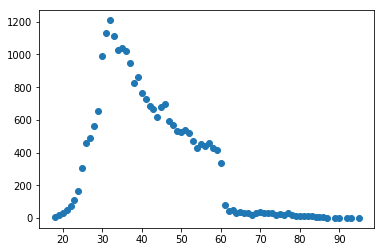

In [38]:
age_data = dict(Counter(dataset_train.iloc[:,1]))
plt.scatter(age_data.keys(), age_data.values())
plt.show()


In [ ]:
cnn_model = Sequential(input_dim)

In [26]:
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=25317, output_dim=2, input_length=16))
    model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(6, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [27]:
train_x = sequence.pad_sequences(x_train, maxlen=500)
val_x = sequence.pad_sequences(x_val, maxlen=500)

In [28]:
model = create_model()
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=100, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 2)             50634     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 16)            112       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 32)            1568      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 32)             3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 32)             0         
__________

InvalidArgumentError: indices[0,7] = -1 is not in [0, 25317)
	 [[Node: embedding_1/embedding_lookup = GatherV2[Taxis=DT_INT32, Tindices=DT_INT32, Tparams=DT_FLOAT, _class=["loc:@training/Adam/Assign_2"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](embedding_1/embeddings/read, embedding_1/Cast, training/Adam/gradients/embedding_1/embedding_lookup_grad/concat/axis)]]

In [94]:
train_x_np = np.array(x_train)
train_y_np = np.array(y_train)
val_x_np = np.array(val_x)
val_y_np = np.array(val_y)
